# Computing Evaluation metrics for bank marketing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

#this is same data downloaded from kaggle in the previous classification task.

In [3]:
df = pd.read_csv(url)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


## Data Preparation and Filling missing values

In [5]:
#sometimes there's not uniformity among the names in the data, so we correct the names to lowercase and fill spaces with underscores

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [6]:
# Create list of numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

# Fill missing values, where numerical features are filled with 0 and categorical features are filled with "NA"
df[numerical_features] = df[numerical_features].fillna(0)
df[categorical_features] = df[categorical_features].fillna("NA")

In [7]:
#check if there are any missing values left
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [8]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [9]:
# Prepare data for modeling
target = "converted"
features = numerical_features + categorical_features
features.remove(target)

## Setting up train/val/test framework

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [11]:
# Training set
df_train = df_train.reset_index(drop=True)
y_train = df_train.converted.values

# val set
df_val = df_val.reset_index(drop=True)
y_val = df_val.converted.values

# Test set
df_test = df_test.reset_index(drop=True)
y_test = df_test.converted.values

In [12]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

## 1. ROC AUC feature importance

This would be used just like the mutual info score. but for the numerical variables.

- Which numerical variable (among the following 4) has the highest AUC?

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
#Dictionary to hold ROC AUC scores
auc_scores = {}

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
# For each numerical variable
for var in numerical:
    auc = roc_auc_score(y_train, df_train[var])

    if auc < 0.5:    #auc = 1 - auc
        auc = roc_auc_score(y_train, -df_train[var])

    auc_scores[var] = auc
    print(f"{var}: {auc:.4f}")

#indicate variable with highest roc auc score
best_var = max(auc_scores, key=auc_scores.get)
print(f"\nNumerical variable with highest AUC: {best_var} with ROC AUC score of {auc_scores[best_var]:.4f}")

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145

Numerical variable with highest AUC: number_of_courses_viewed with ROC AUC score of 0.7636


## 2. Training the model

- we apply one hot encoding using DictVectorizer 
- Next, we train using Logistic Regression



In [15]:
#First, we can create a function to train the model, 
#which will take the training dataframe and target values as input parameters,while applying one-hot encoding using DictVectorizer and training using Logistic Regression.

def train(df_train, y_train, C = 1.0):   #default value of c = 1.0
    dicts = df_train[features].to_dict(orient='records')


# one-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train =dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train,y_train)

    return dv, model


In [16]:
dv, model = train(df_train, y_train, C=1.0)

In [17]:
def predict(df_train, dv, model):
    dicts = df_train[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [18]:
y_pred = predict(df_val, dv, model)

In [19]:
#using scikit learn roc_auc to test model on val set.

roc_auc_score(y_val,y_pred) 

0.8171316268814112

#### Note: Using the lbgs solver above in the model logistic regression, gets us close to 0.92 expected in the homework. Somehow liblinear gives a different output. 0.817, except when the data is scaled. Then both solvers give almost same output.

In [20]:
#NB, using a standard scaler to scale the features before training the model, gives an AUC that is closer to the Homework options.

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Convert dataframes to dictionaries for DictVectorizer
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_pred = model.predict_proba(X_val_scaled)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation dataset: {auc:.3f}")

AUC on validation dataset: 0.921


## 3. Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [21]:
# Define thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

for t in thresholds:
    converted_decision = (y_pred >= t)
    score = (y_val == converted_decision).mean()
    print('%.2f, %.3f' % (t, score))
    scores.append(score)

#Here, score means the accuracy.

#The above can also be implemented 
# froms sklearn.metrics import accuracy_score
#score = accuracy_score(y_val,y_pred >= t)
# print('%.2f, %.3f' % (t, score))
# scores.append(score)

0.00, 0.584
0.01, 0.604
0.02, 0.631
0.03, 0.635
0.04, 0.652
0.05, 0.655
0.06, 0.662
0.07, 0.666
0.08, 0.666
0.09, 0.669
0.10, 0.676
0.11, 0.683
0.12, 0.686
0.13, 0.693
0.14, 0.696
0.15, 0.706
0.16, 0.710
0.17, 0.724
0.18, 0.741
0.19, 0.751
0.20, 0.765
0.21, 0.765
0.22, 0.765
0.23, 0.765
0.24, 0.782
0.25, 0.785
0.26, 0.788
0.27, 0.795
0.28, 0.802
0.29, 0.805
0.30, 0.809
0.31, 0.819
0.32, 0.826
0.33, 0.836
0.34, 0.829
0.35, 0.840
0.36, 0.833
0.37, 0.833
0.38, 0.833
0.39, 0.833
0.40, 0.836
0.41, 0.840
0.42, 0.840
0.43, 0.840
0.44, 0.840
0.45, 0.840
0.46, 0.843
0.47, 0.843
0.48, 0.846
0.49, 0.850
0.50, 0.846
0.51, 0.857
0.52, 0.853
0.53, 0.853
0.54, 0.846
0.55, 0.850
0.56, 0.853
0.57, 0.853
0.58, 0.857
0.59, 0.853
0.60, 0.846
0.61, 0.846
0.62, 0.843
0.63, 0.850
0.64, 0.850
0.65, 0.853
0.66, 0.857
0.67, 0.850
0.68, 0.846
0.69, 0.843
0.70, 0.846
0.71, 0.840
0.72, 0.843
0.73, 0.843
0.74, 0.843
0.75, 0.840
0.76, 0.840
0.77, 0.833
0.78, 0.836
0.79, 0.833
0.80, 0.829
0.81, 0.819
0.82, 0.816
0.83

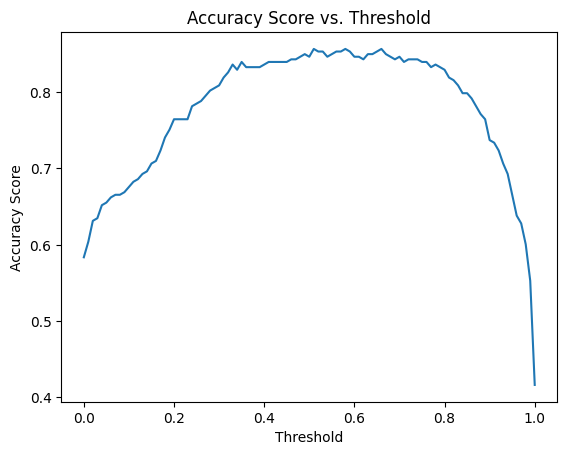

In [23]:
plt.plot(thresholds, scores)
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs. Threshold')
plt.show()

In [24]:
#Calculating Precision and Recall for different thresholds

thresholds = np.arange(0.0, 1.01, 0.01)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

precisions = []
recalls = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    Precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    Recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(Precision)
    recalls.append(Recall)

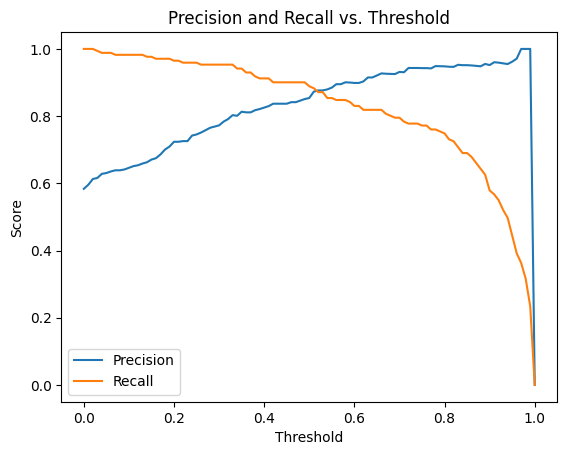

In [25]:
#Plot Precision and Recall vs. Threshold
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

In [ ]:
#this can also be done using sklearn.metrics
#from sklearn.metrics import precision_score, recall_score
#precisions = []
#recalls = []
#for t in thresholds:
#    predict_positive = (y_pred >= t)    
#    Precision = precision_score(y_val, predict_positive)
#    Recall = recall_score(y_val, predict_positive)
#    precisions.append(Precision)
#    recalls.append(Recall)

In [32]:
# Find where precision and recall cross
for i in range(len(thresholds) - 1):
    # Check if they cross between threshold i and i+1
    if (precisions[i] >= recalls[i] and precisions[i+1] <= recalls[i+1]) or \
       (precisions[i] <= recalls[i] and precisions[i+1] >= recalls[i+1]):
        # Linear interpolation to find exact crossing point
        t1, t2 = thresholds[i], thresholds[i+1]
        p1, p2 = precisions[i], precisions[i+1]
        r1, r2 = recalls[i], recalls[i+1]
        
        # Intersection threshold (interpolated)
        intersection = (t1 + t2) / 2  # Simple midpoint approximation
        
        print(f"Intersection between {t1:.2f} and {t2:.2f}")
        print(f"Approximate intersection threshold: {intersection:.2f}")
        
        break #stop after first intersection found.
    

Intersection between 0.51 and 0.52
Approximate intersection threshold: 0.52


## 4. F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

- At which threshold F1 is maximal?

In [36]:
F1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    Precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    Recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if Precision + Recall > 0:
        F1 = 2 * (Precision * Recall) / (Precision + Recall)
    else:
        F1 = 0

    F1_scores.append(F1)    

# Find the threshold with maximum F1 score
Max_F1 = max(F1_scores)
Max_index = F1_scores.index(Max_F1)
Best_threshold = thresholds[Max_index]

print(f"Maximum F1 score: {Max_F1:.4f} at threshold: {Best_threshold:.2f}")

Maximum F1 score: 0.8779 at threshold: 0.51


In [37]:
# Using sklearn to compute F1 score for different thresholds
from sklearn.metrics import f1_score

# Lists to store F1 scores
f1_scores = []

for t in thresholds:
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred_binary, zero_division=0)
    
    f1_scores.append(f1)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_idx]

print(f"Best F1 Score: {f1_scores[max_f1_idx]:.3f}")
print(f"At threshold: {best_threshold:.2f}")

Best F1 Score: 0.878
At threshold: 0.51


## 5. 5-fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?



In [39]:
from sklearn.model_selection import KFold

In [41]:
#initialise kfold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x7268c5902df0>

In [44]:
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx),len(df_full_train)

(935, 234, 1169)

In [46]:
def train(df, y_train, C = 1.0):   #default value of c = 1.0
    dicts = df[features].to_dict(orient='records')


# one-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train =dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train,y_train)

    return dv, model

In [47]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [56]:
n_splits = 5
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
# Split the data into train and validation for this fold
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values

    del df_train_fold['converted']
    del df_val_fold['converted']

    dv, model = train(df_train_fold, y_train_fold, C=1.0) #NB train function defined earlier.
    y_pred = predict(df_val_fold, dv, model)    #predict function defined earlier.

    auc = roc_auc_score(y_val_fold, y_pred)
    auc_scores.append(auc)
    print(f"Fold {fold}: AUC = {auc:.3f}")

# Calculate mean and standard deviation
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nMean AUC: {mean_auc:.3f}")
print(f"Std AUC: {std_auc:.3f}")
print(f"AUC scores: {[f'{score:.3f}' for score in auc_scores]}")


Fold 1: AUC = 0.806
Fold 2: AUC = 0.871
Fold 3: AUC = 0.775
Fold 4: AUC = 0.802
Fold 5: AUC = 0.856

Mean AUC: 0.822
Std AUC: 0.036
AUC scores: ['0.806', '0.871', '0.775', '0.802', '0.856']


## 6. Hyperparameter Tuning.

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
- Which C leads to the best mean score?


In [68]:
results = {}
c_values = [0.000001, 0.001, 1]

for c in c_values: #always best to use lowercase for variable names, like for 'c' = c_values.
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    # Split the data into train and validation for this fold
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values

        del df_train_fold['converted']
        del df_val_fold['converted']

        dv, model = train(df_train_fold, y_train_fold, C=c) #NB train function defined earlier.
        y_pred = predict(df_val_fold, dv, model)    #predict function defined earlier.

        auc = roc_auc_score(y_val_fold, y_pred)
        auc_scores.append(auc)

    print(f'C={c}: %.3f +- %.3f' % (np.mean(auc_scores), np.std(auc_scores)))




C=1e-06: 0.560 +- 0.024
C=0.001: 0.867 +- 0.029
C=1: 0.822 +- 0.036
